**Importing libraries and loading the data**

In [8]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn  as sns
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import math
import xgboost as xgb
import pickle
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


In [9]:
#loading all needed datasets from kaggle
calendar = pd.read_csv('../data/raw/calendar.csv')
sell_prices = pd.read_csv('../data/raw/sell_prices.csv')
sales_validation = pd.read_csv('../data/raw/sales_train_validation.csv')


In [10]:
print(sell_prices.head())

  store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26


In [11]:
print(sales_validation.head())

                              id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  d_1908  \
0       CA    0    0    0    0  ...       1       3       0       1       1   
1       CA    0    0    0    0  ...       0       0       0       0       0   
2       CA    0    0    0    0  ...       2       1       2       1       1   
3       CA    0    0    0    0  ...       1       0       5       4       1   
4       CA    0    0    0    0  ...       2       1       1       0       1   

   d_1909  d_1910  d_1911  d_1912  d_1913  


In [12]:
print(calendar.head())
print(calendar.date.max())

         date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1  
2016-06-19


In [13]:
merged_df = pd.merge(calendar, sell_prices, on='wm_yr_wk', how='left')
print(merged_df)

                date  wm_yr_wk   weekday  wday  month  year       d  \
0         2011-01-29     11101  Saturday     1      1  2011     d_1   
1         2011-01-29     11101  Saturday     1      1  2011     d_1   
2         2011-01-29     11101  Saturday     1      1  2011     d_1   
3         2011-01-29     11101  Saturday     1      1  2011     d_1   
4         2011-01-29     11101  Saturday     1      1  2011     d_1   
...              ...       ...       ...   ...    ...   ...     ...   
47735392  2016-06-19     11621    Sunday     2      6  2016  d_1969   
47735393  2016-06-19     11621    Sunday     2      6  2016  d_1969   
47735394  2016-06-19     11621    Sunday     2      6  2016  d_1969   
47735395  2016-06-19     11621    Sunday     2      6  2016  d_1969   
47735396  2016-06-19     11621    Sunday     2      6  2016  d_1969   

          event_name_1 event_type_1  event_name_2 event_type_2  snap_CA  \
0                  NaN          NaN           NaN          NaN        0 

**Exploratory Data Analysis**

In [14]:
item = pd.read_csv('../data/raw/item_id_sample.csv')
print(item.head())

   Unnamed: 0        item_id    dept_id
0          48  HOBBIES_1_049  HOBBIES_1
1         381  HOBBIES_1_390  HOBBIES_1
2         150  HOBBIES_1_155  HOBBIES_1
3         287  HOBBIES_1_296  HOBBIES_1
4         415  HOBBIES_1_424  HOBBIES_1


In [15]:
# # by using merge we can as join the two datasets together as filter out all the useless combinations
# filtered_df = pd.merge(sales_validation, item[['item_id', 'dept_id']],
#                                      how='inner',
#                                      on=['item_id', 'dept_id'])

# # diagnostic stuff
# print("Number of rows before filtering:", len(sales_validation))
# print("Number of rows after filtering:", len(filtered_df))
# print(filtered_df.head())


In [16]:
melted_filtered_df = pd.melt(sales_validation,
                             id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
                             var_name='d',
                             value_name='sales')
print(melted_filtered_df.head())
print(melted_filtered_df.d.unique()) # error check
print(melted_filtered_df.sales.unique())
print(len(melted_filtered_df))

                              id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id    d  sales  
0       CA  d_1      0  
1       CA  d_1      0  
2       CA  d_1      0  
3       CA  d_1      0  
4       CA  d_1      0  
['d_1' 'd_2' 'd_3' ... 'd_1911' 'd_1912' 'd_1913']
[  0  12   2   4   5   9   3   1  25  45  10   8   7  16  54   6  50  14
  11  17  15  23  13  20  19  38  32  21  30  33 107  51  26 147  22  43
  24  35  27  42  49  36  18  37 116  56  28  34  41  31  39  44 108  55
 360  62  69  75 125  53  47  29 164  52 102  63  98  59 203 152  65 115
  46  57  90  58  78  64 1

In [17]:
merged_df = pd.merge(melted_filtered_df, calendar, how='inner', on='d')
print(merged_df.head())
print(merged_df.columns) # see we have four different columns connected into events.let's make them 2!
print(len(merged_df))
print(merged_df.date.max())

                              id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id    d  sales        date  wm_yr_wk  ... wday  month  year  \
0       CA  d_1      0  2011-01-29     11101  ...    1      1  2011   
1       CA  d_1      0  2011-01-29     11101  ...    1      1  2011   
2       CA  d_1      0  2011-01-29     11101  ...    1      1  2011   
3       CA  d_1      0  2011-01-29     11101  ...    1      1  2011   
4       CA  d_1      0  2011-01-29     11101  ...    1      1  2011   

   event_name_1 event_type_1 event_name_2 event_type_2 snap_CA  snap_TX  \
0           NaN  

In [18]:
print(merged_df.event_type_1.unique())
print(merged_df.event_type_2.unique())
print(merged_df.event_name_1.unique())
print(merged_df.event_name_2.unique())

[nan 'Sporting' 'Cultural' 'National' 'Religious']
[nan 'Cultural' 'Religious']
[nan 'SuperBowl' 'ValentinesDay' 'PresidentsDay' 'LentStart' 'LentWeek2'
 'StPatricksDay' 'Purim End' 'OrthodoxEaster' 'Pesach End' 'Cinco De Mayo'
 "Mother's day" 'MemorialDay' 'NBAFinalsStart' 'NBAFinalsEnd'
 "Father's day" 'IndependenceDay' 'Ramadan starts' 'Eid al-Fitr'
 'LaborDay' 'ColumbusDay' 'Halloween' 'EidAlAdha' 'VeteransDay'
 'Thanksgiving' 'Christmas' 'Chanukah End' 'NewYear' 'OrthodoxChristmas'
 'MartinLutherKingDay' 'Easter']
[nan 'Easter' 'Cinco De Mayo' 'OrthodoxEaster' "Father's day"]


In [19]:
# melt (aka make them long-form rather than wide-form)
df_event_name_melted = pd.melt(merged_df,
                               id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd', 'sales', 'date'],
                               value_vars=['event_name_1', 'event_name_2'],
                               var_name='event_name_type',
                               value_name='event_name')
df_event_type_melted = pd.melt(merged_df,
                               id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd', 'sales', 'date'],
                               value_vars=['event_type_1', 'event_type_2'],
                               var_name='event_type_type',
                               value_name='event_type')
df_event_name_melted.drop('event_name_type', axis=1, inplace=True)
df_event_type_melted.drop('event_type_type', axis=1, inplace=True)

sort_columns = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd', 'sales', 'date']

df_event_name_melted.sort_values(by=sort_columns, inplace=True)
df_event_type_melted.sort_values(by=sort_columns, inplace=True)

cols_event_name = ['event_name']
cols_event_type = ['event_type']

final_df = pd.concat([df_event_name_melted[sort_columns],
                      merged_df[['wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'snap_CA', 'snap_TX', 'snap_WI']],
                      df_event_name_melted[cols_event_name],
                      df_event_type_melted[cols_event_type]], axis=1)
final_df.dropna(subset=['weekday', 'month'], inplace=True)


In [ ]:
nan_count = final_df.isna().sum()

# sum of nan values in all columns
print("Sum of NaN values in each column:")
print(nan_count)
print(f"total rows: {len(final_df)}")

Sum of NaN values in each column:
id                  0
item_id             0
dept_id             0
cat_id              0
store_id            0
state_id            0
d                   0
sales               0
date                0
wm_yr_wk            0
weekday             0
wday                0
month               0
year                0
snap_CA             0
snap_TX             0
snap_WI             0
event_name    1231300
event_type    1231300
dtype: int64
total rows: 1339100


In [ ]:
# sell prices dataframe is still missing, so here we go!
print(sell_prices.head())
print(sell_prices.dtypes)

  store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26
store_id       object
item_id        object
wm_yr_wk        int64
sell_price    float64
dtype: object


In [ ]:
#print(final_df.head()) # the wm_yr_wk column is float and has decimal places, in comparison to sell_prices wm_yr_wk col which does not have decimal places
#print(final_df.dtypes)
final_df['wm_yr_wk'] = final_df['wm_yr_wk'].astype(int)
final_df['wm_yr_wk'] = final_df['wm_yr_wk'].astype('object')
print(final_df.head())

                                 id      item_id  dept_id cat_id store_id  \
400     FOODS_1_011_CA_1_validation  FOODS_1_011  FOODS_1  FOODS     CA_1   
6700    FOODS_1_011_CA_1_validation  FOODS_1_011  FOODS_1  FOODS     CA_1   
69700   FOODS_1_011_CA_1_validation  FOODS_1_011  FOODS_1  FOODS     CA_1   
699700  FOODS_1_011_CA_1_validation  FOODS_1_011  FOODS_1  FOODS     CA_1   
700400  FOODS_1_011_CA_1_validation  FOODS_1_011  FOODS_1  FOODS     CA_1   

       state_id       d  sales        date wm_yr_wk   weekday  wday  month  \
400          CA     d_1      2  2011-01-29    11101  Saturday   1.0    1.0   
6700         CA    d_10      1  2011-02-07    11102    Monday   3.0    2.0   
69700        CA   d_100      0  2011-05-08    11115    Sunday   2.0    5.0   
699700       CA  d_1000      0  2013-10-24    11339  Thursday   6.0   10.0   
700400       CA  d_1001      0  2013-10-25    11339    Friday   7.0   10.0   

          year  snap_CA  snap_TX  snap_WI    event_name event_type  

In [ ]:
final_df = pd.merge(final_df,
                    sell_prices[['store_id', 'item_id', 'wm_yr_wk', 'sell_price']],
                    on=['store_id', 'item_id', 'wm_yr_wk'],
                    how='left')

In [ ]:
final_df['weekday_binary'] = final_df['weekday'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0) #1=this day is weekend
final_df['event_binary'] = final_df['event_name'].apply(lambda x: 0 if pd.isna(x) else 1) #1=this day is some event

In [ ]:
print(final_df.head())

                            id      item_id  dept_id cat_id store_id state_id  \
0  FOODS_1_011_CA_1_validation  FOODS_1_011  FOODS_1  FOODS     CA_1       CA   
1  FOODS_1_011_CA_1_validation  FOODS_1_011  FOODS_1  FOODS     CA_1       CA   
2  FOODS_1_011_CA_1_validation  FOODS_1_011  FOODS_1  FOODS     CA_1       CA   
3  FOODS_1_011_CA_1_validation  FOODS_1_011  FOODS_1  FOODS     CA_1       CA   
4  FOODS_1_011_CA_1_validation  FOODS_1_011  FOODS_1  FOODS     CA_1       CA   

        d  sales        date wm_yr_wk  ... month    year  snap_CA  snap_TX  \
0     d_1      2  2011-01-29    11101  ...   1.0  2011.0      0.0      0.0   
1    d_10      1  2011-02-07    11102  ...   2.0  2011.0      1.0      1.0   
2   d_100      0  2011-05-08    11115  ...   5.0  2011.0      1.0      0.0   
3  d_1000      0  2013-10-24    11339  ...  10.0  2013.0      0.0      0.0   
4  d_1001      0  2013-10-25    11339  ...  10.0  2013.0      0.0      0.0   

   snap_WI    event_name  event_type sell_pr

In [ ]:
final_df = final_df.drop_duplicates()
print(final_df.isna().sum())

print(final_df.notna().sum())
print(final_df.shape)
print(final_df.date.max())

id                      0
item_id                 0
dept_id                 0
cat_id                  0
store_id                0
state_id                0
d                       0
sales                   0
date                    0
wm_yr_wk                0
weekday                 0
wday                    0
month                   0
year                    0
snap_CA                 0
snap_TX                 0
snap_WI                 0
event_name        1231300
event_type        1231300
sell_price         202188
weekday_binary          0
event_binary            0
dtype: int64
id                1339100
item_id           1339100
dept_id           1339100
cat_id            1339100
store_id          1339100
state_id          1339100
d                 1339100
sales             1339100
date              1339100
wm_yr_wk          1339100
weekday           1339100
wday              1339100
month             1339100
year              1339100
snap_CA           1339100
snap_TX           1339100

In [ ]:
filtered_df = final_df[final_df['sell_price'].isna()]
filtered_df.drop_duplicates()
print(filtered_df.isna().sum())
filtered_df.date.max()


id                     0
item_id                0
dept_id                0
cat_id                 0
store_id               0
state_id               0
d                      0
sales                  0
date                   0
wm_yr_wk               0
weekday                0
wday                   0
month                  0
year                   0
snap_CA                0
snap_TX                0
snap_WI                0
event_name        185439
event_type        185439
sell_price        202188
weekday_binary         0
event_binary           0
dtype: int64


'2015-12-25'

In [ ]:
print(filtered_df.head())

                               id      item_id  dept_id cat_id store_id  \
1913  FOODS_1_011_CA_2_validation  FOODS_1_011  FOODS_1  FOODS     CA_2   
1914  FOODS_1_011_CA_2_validation  FOODS_1_011  FOODS_1  FOODS     CA_2   
2025  FOODS_1_011_CA_2_validation  FOODS_1_011  FOODS_1  FOODS     CA_2   
2136  FOODS_1_011_CA_2_validation  FOODS_1_011  FOODS_1  FOODS     CA_2   
2247  FOODS_1_011_CA_2_validation  FOODS_1_011  FOODS_1  FOODS     CA_2   

     state_id     d  sales        date wm_yr_wk  ... month    year  snap_CA  \
1913       CA   d_1      0  2011-01-29    11101  ...   1.0  2011.0      0.0   
1914       CA  d_10      0  2011-02-07    11102  ...   2.0  2011.0      1.0   
2025       CA  d_11      0  2011-02-08    11102  ...   2.0  2011.0      1.0   
2136       CA  d_12      0  2011-02-09    11102  ...   2.0  2011.0      1.0   
2247       CA  d_13      0  2011-02-10    11102  ...   2.0  2011.0      1.0   

      snap_TX  snap_WI  event_name  event_type sell_price weekday_binary  

In [ ]:
#sell price is misssing
mean_prices = filtered_df.groupby('id')['sell_price'].transform('mean')

# Replace NaN values in 'sell_price' with corresponding mean price
filtered_df['sell_price'].fillna(mean_prices, inplace=True)


<ipython-input-88-5a330ae281e1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['sell_price'].fillna(mean_prices, inplace=True)


In [ ]:
filtered_df.isna().sum()

id                     0
item_id                0
dept_id                0
cat_id                 0
store_id               0
state_id               0
d                      0
sales                  0
date                   0
wm_yr_wk               0
weekday                0
wday                   0
month                  0
year                   0
snap_CA                0
snap_TX                0
snap_WI                0
event_name        185439
event_type        185439
sell_price        202188
weekday_binary         0
event_binary           0
dtype: int64

In [ ]:
unique_item_ids_not_in_item = filtered_df.loc[~filtered_df['item_id'].isin(item['item_id']), 'item_id'].unique()
unique_dept_ids_not_in_item = filtered_df.loc[~filtered_df['dept_id'].isin(item['dept_id']), 'dept_id'].unique()
print("Unique item_ids in 'sales_validation' that are NOT in 'item':", unique_item_ids_not_in_item)
print("Unique dept_ids in 'sales_validation' that are NOT in 'item':", unique_dept_ids_not_in_item)


Unique item_ids in 'sales_validation' that are NOT in 'item': []
Unique dept_ids in 'sales_validation' that are NOT in 'item': []


In [ ]:
#change column d type from string to inteager
final_df.d = final_df.d.str.replace("d_","")
final_df.d = final_df.d.astype(int)
print(final_df.d)

0             1
1            10
2           100
3          1000
4          1001
           ... 
1339095     995
1339096     996
1339097     997
1339098     998
1339099     999
Name: d, Length: 1339100, dtype: int64


In [ ]:
#new column profit
final_df["profit"] = final_df.sales * final_df.sell_price
final_df = final_df.dropna(subset=["profit"])
print(f"Count of na values in column profit: {final_df.profit.isna().sum()}")

Count of na values in column profit: 0


In [ ]:
#Length of dataframe after drop
len(final_df)

1136912

In [ ]:
print(final_df.head())
df = final_df

                            id      item_id  dept_id cat_id store_id state_id  \
0  FOODS_1_011_CA_1_validation  FOODS_1_011  FOODS_1  FOODS     CA_1       CA   
1  FOODS_1_011_CA_1_validation  FOODS_1_011  FOODS_1  FOODS     CA_1       CA   
2  FOODS_1_011_CA_1_validation  FOODS_1_011  FOODS_1  FOODS     CA_1       CA   
3  FOODS_1_011_CA_1_validation  FOODS_1_011  FOODS_1  FOODS     CA_1       CA   
4  FOODS_1_011_CA_1_validation  FOODS_1_011  FOODS_1  FOODS     CA_1       CA   

      d  sales        date wm_yr_wk  ...    year  snap_CA  snap_TX  snap_WI  \
0     1      2  2011-01-29    11101  ...  2011.0      0.0      0.0      0.0   
1    10      1  2011-02-07    11102  ...  2011.0      1.0      1.0      0.0   
2   100      0  2011-05-08    11115  ...  2011.0      1.0      0.0      1.0   
3  1000      0  2013-10-24    11339  ...  2013.0      0.0      0.0      0.0   
4  1001      0  2013-10-25    11339  ...  2013.0      0.0      0.0      0.0   

     event_name  event_type  sell_pric

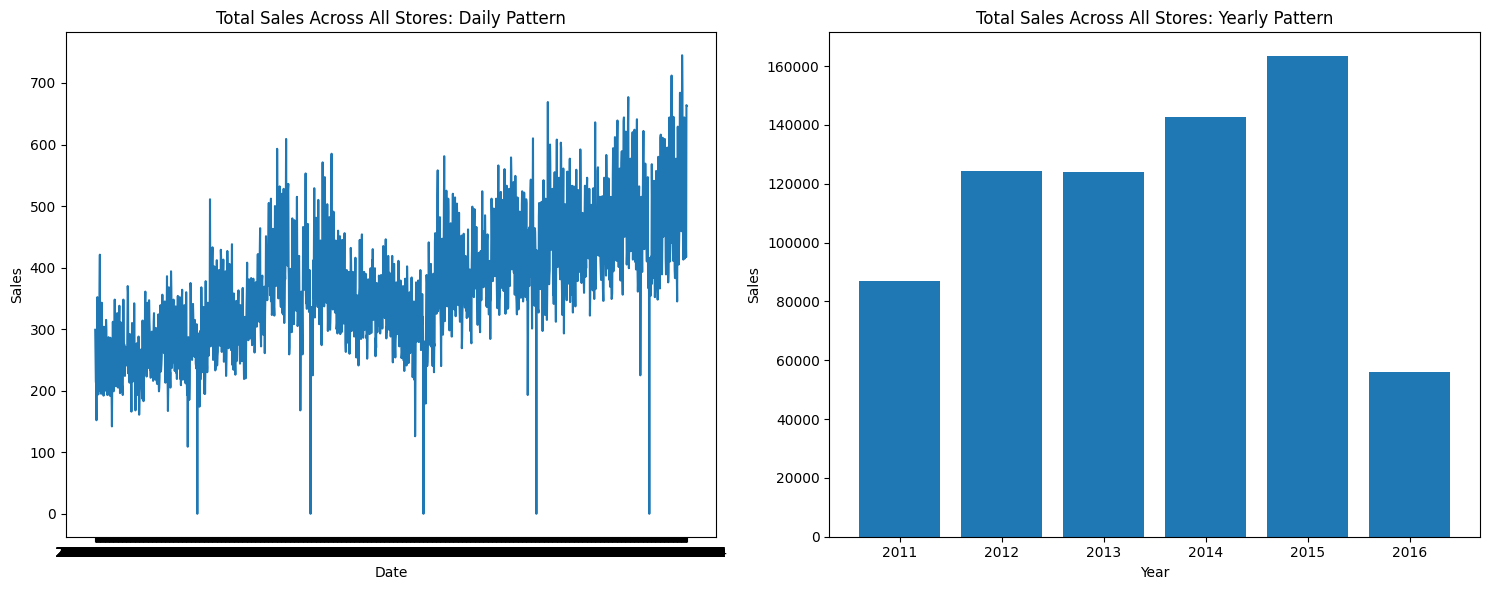

In [ ]:
# --- Plotting Total Sales Across All Stores: Daily and Yearly Pattern ---
# Grouping by date and summing sales
daily_sales = df.groupby('date')['sales'].sum().reset_index()
yearly_sales = df.groupby('year')['sales'].sum().reset_index()

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(daily_sales['date'], daily_sales['sales'])
plt.title("Total Sales Across All Stores: Daily Pattern")
plt.xlabel('Date')
plt.ylabel('Sales')

plt.subplot(1, 2, 2)
plt.bar(yearly_sales['year'], yearly_sales['sales'])
plt.title("Total Sales Across All Stores: Yearly Pattern")
plt.xlabel('Year')
plt.ylabel('Sales')

plt.tight_layout()
plt.show()


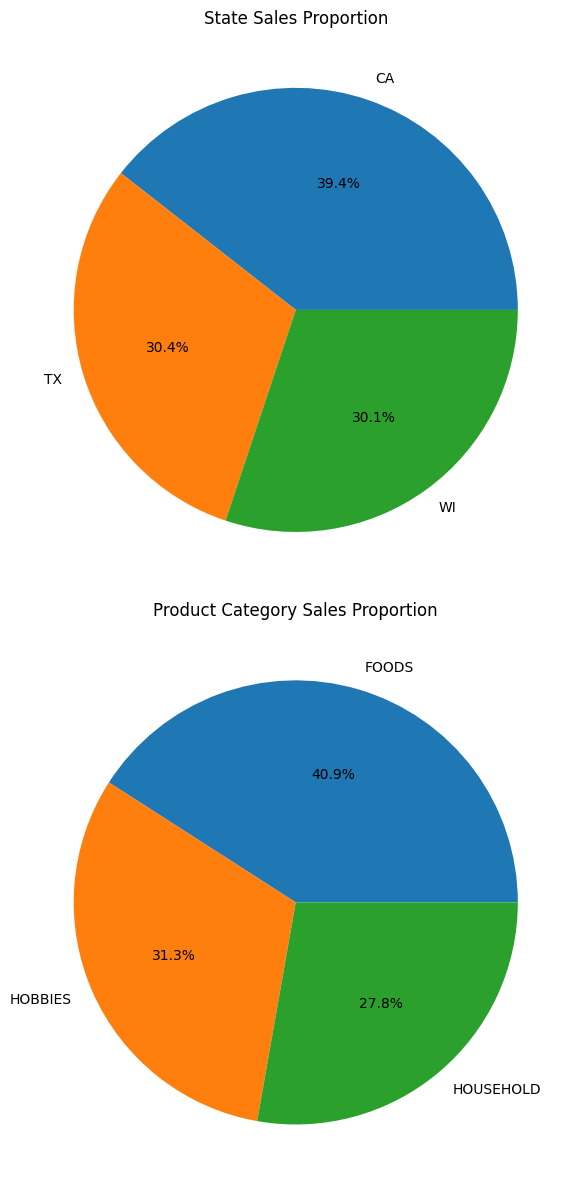

In [ ]:
# --- Plotting Proportions: State, Store, Product Category, Department ---
def plot_pie_chart(column_name, title):
    proportions = df[column_name].value_counts(normalize=True).reset_index()
    plt.pie(proportions[column_name], labels=proportions['index'], autopct='%1.1f%%')
    plt.title(title)

def plot_horizontal_bar_chart(column_name, title):
    proportions = df.groupby(column_name)['sales'].sum().sort_values(ascending=True)
    proportions.plot(kind='barh', figsize=(10, 6))
    plt.xlabel('Total Sales')
    plt.title(title)
    plt.show()

plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plot_pie_chart('state_id', 'State Sales Proportion')

plt.subplot(2, 2, 3)
plot_pie_chart('cat_id', 'Product Category Sales Proportion')
plt.tight_layout()
plt.show()


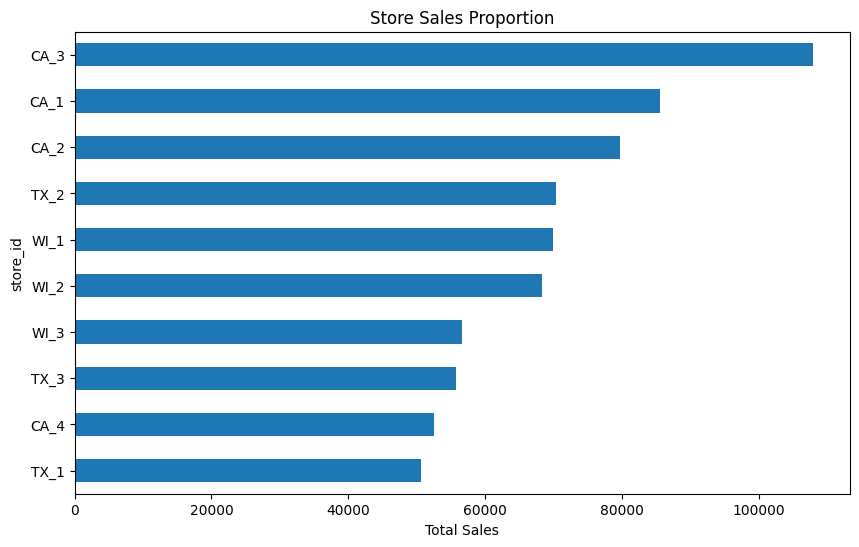

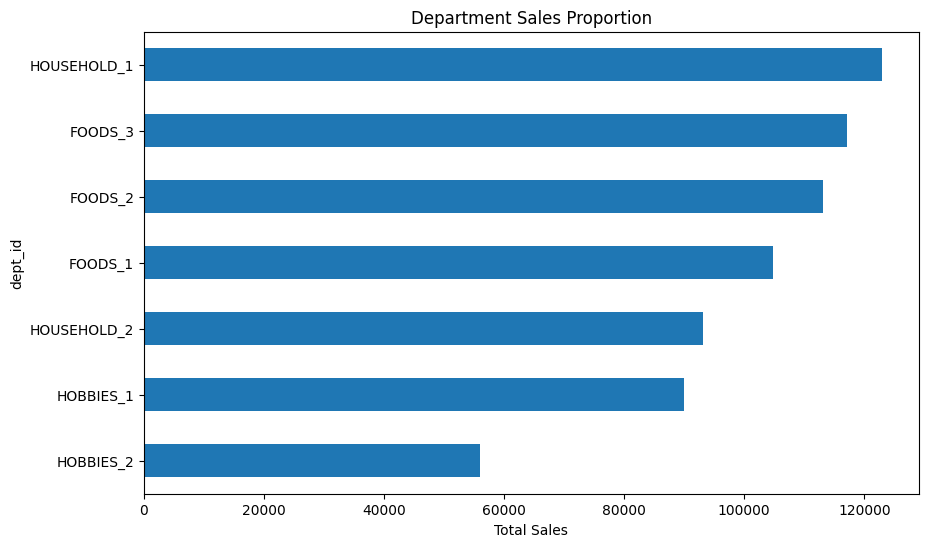

<Figure size 640x480 with 0 Axes>

In [ ]:
# Store Sales Proportion
plot_horizontal_bar_chart('store_id', 'Store Sales Proportion')

# Department Sales Proportion
plot_horizontal_bar_chart('dept_id', 'Department Sales Proportion')

plt.tight_layout()
plt.show()


Text(0.5, 0, 'Product Category')

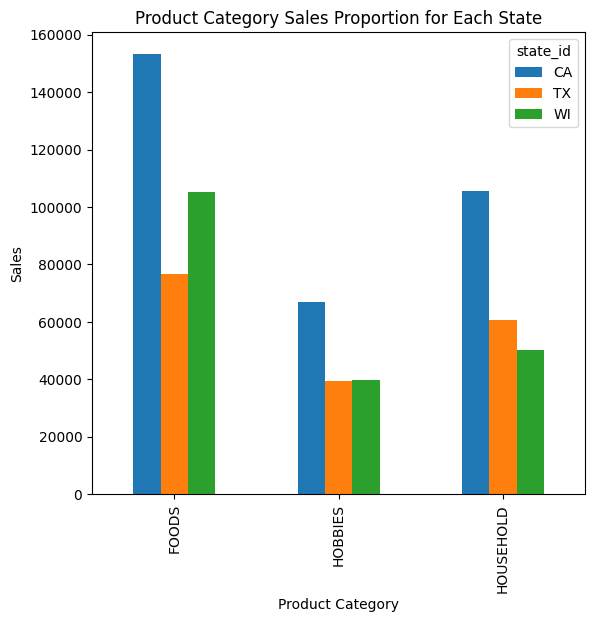

In [ ]:
# --- Product Category Sales Proportion for Each State ---
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
category_state = df.groupby(['state_id', 'cat_id'])['sales'].sum().unstack().T
category_state.plot(kind='bar', ax=plt.gca())
plt.title("Product Category Sales Proportion for Each State")
plt.ylabel("Sales")
plt.xlabel("Product Category")


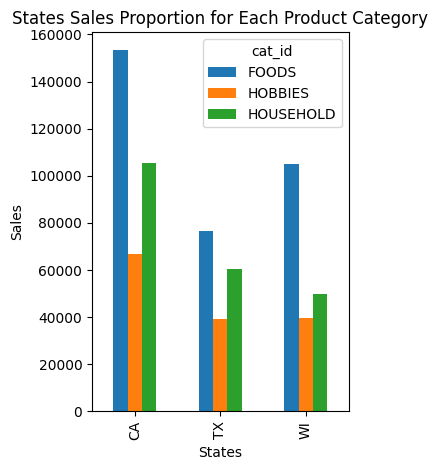

In [ ]:
# --- States Sales Proportion for Each Product Category ---
plt.subplot(1, 2, 2)
state_category = df.groupby(['cat_id', 'state_id'])['sales'].sum().unstack().T
state_category.plot(kind='bar', ax=plt.gca())
plt.title("States Sales Proportion for Each Product Category")
plt.ylabel("Sales")
plt.xlabel("States")

plt.tight_layout()
plt.show()


event_binary
0    0.616339
1    0.575787
Name: sales, dtype: float64


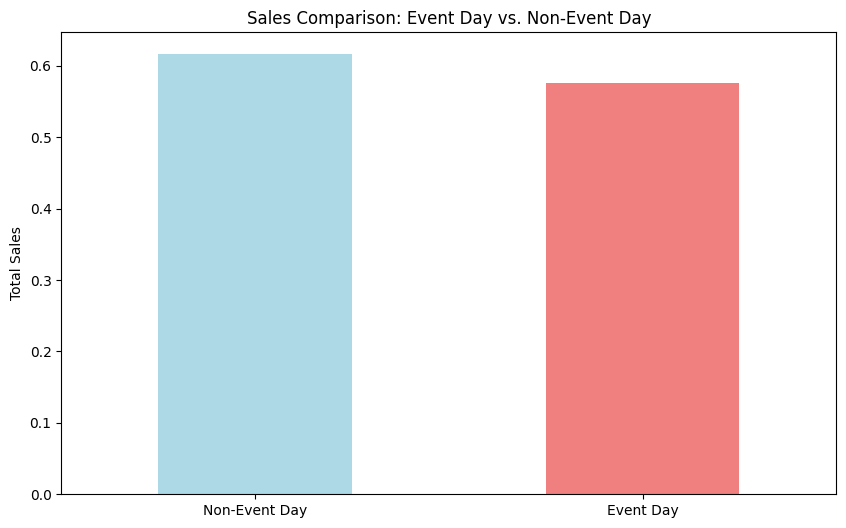

In [ ]:
event_sales = df.groupby('event_binary')['sales'].mean()
print(event_sales)
# Plotting
plt.figure(figsize=(10, 6))
event_sales.plot(kind='bar', color=['lightblue', 'lightcoral'])

# Adding the labels and title
plt.xticks(ticks=[0, 1], labels=['Non-Event Day', 'Event Day'], rotation=0)
plt.ylabel('Total Sales')
plt.xlabel('')
plt.title('Sales Comparison: Event Day vs. Non-Event Day')

plt.show()

# strange

In [ ]:
print(event_sales)
print(df.isna().sum())

event_binary
0    0.616339
1    0.575787
Name: sales, dtype: float64
id                      0
item_id                 0
dept_id                 0
cat_id                  0
store_id                0
state_id                0
d                       0
sales                   0
date                    0
wm_yr_wk                0
weekday                 0
wday                    0
month                   0
year                    0
snap_CA                 0
snap_TX                 0
snap_WI                 0
event_name        1045861
event_type        1045861
sell_price              0
weekday_binary          0
event_binary            0
profit                  0
dtype: int64


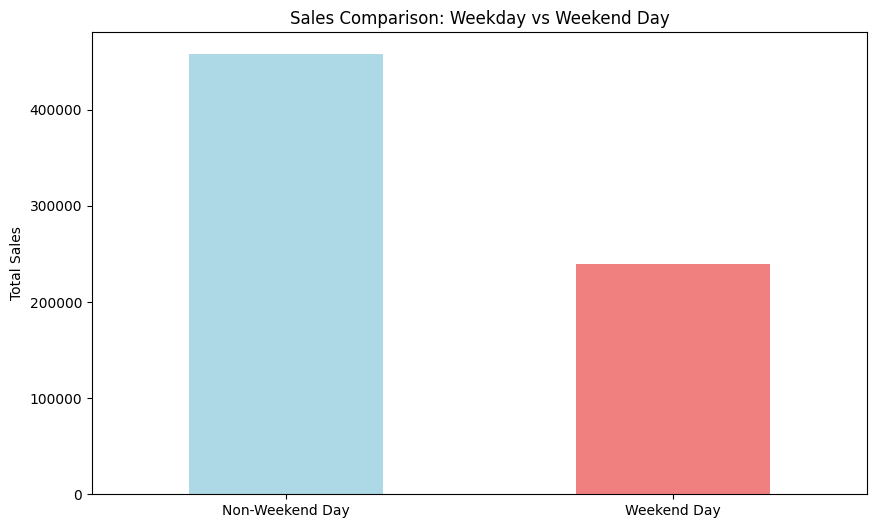

In [ ]:
event_sales = df.groupby('weekday_binary')['sales'].sum()

# Plotting
plt.figure(figsize=(10, 6))
event_sales.plot(kind='bar', color=['lightblue', 'lightcoral'])

# Adding the labels and title
plt.xticks(ticks=[0, 1], labels=['Non-Weekend Day', 'Weekend Day'], rotation=0)
plt.ylabel('Total Sales')
plt.xlabel('')
plt.title('Sales Comparison: Weekday vs Weekend Day')

plt.show()

# strange

In [ ]:
print(df.head())

                            id      item_id  dept_id cat_id store_id state_id  \
0  FOODS_1_011_CA_1_validation  FOODS_1_011  FOODS_1  FOODS     CA_1       CA   
1  FOODS_1_011_CA_1_validation  FOODS_1_011  FOODS_1  FOODS     CA_1       CA   
2  FOODS_1_011_CA_1_validation  FOODS_1_011  FOODS_1  FOODS     CA_1       CA   
3  FOODS_1_011_CA_1_validation  FOODS_1_011  FOODS_1  FOODS     CA_1       CA   
4  FOODS_1_011_CA_1_validation  FOODS_1_011  FOODS_1  FOODS     CA_1       CA   

      d  sales        date wm_yr_wk  ...    year  snap_CA  snap_TX  snap_WI  \
0     1      2  2011-01-29    11101  ...  2011.0      0.0      0.0      0.0   
1    10      1  2011-02-07    11102  ...  2011.0      1.0      1.0      0.0   
2   100      0  2011-05-08    11115  ...  2011.0      1.0      0.0      1.0   
3  1000      0  2013-10-24    11339  ...  2013.0      0.0      0.0      0.0   
4  1001      0  2013-10-25    11339  ...  2013.0      0.0      0.0      0.0   

     event_name  event_type  sell_pric

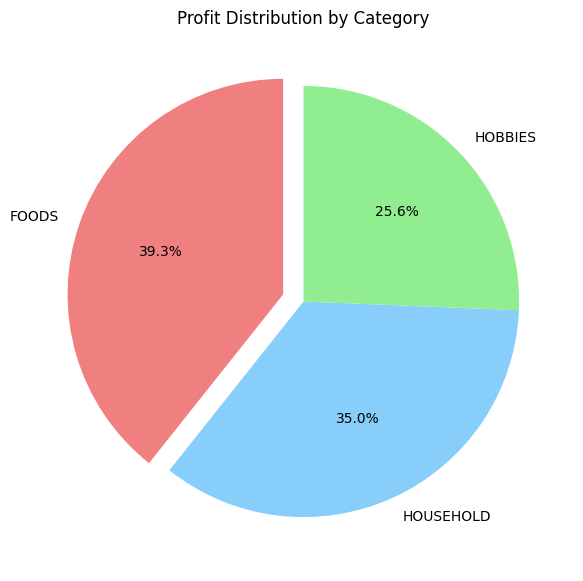

In [ ]:
profit_by_cat = df.groupby('cat_id')['profit'].sum()

# Calculate percentage contribution of each category to overall profit
profit_percent = profit_by_cat / profit_by_cat.sum() * 100

# Sort values for better visualization
sorted_profit_percent = profit_percent.sort_values(ascending=False)

# Plot
fig, ax = plt.subplots(figsize=(10, 7))
sorted_profit_percent.plot(kind='pie', ax=ax, autopct='%1.1f%%', startangle=90, legend=False,
                           colors=['lightcoral', 'lightskyblue', 'lightgreen'],
                           explode=(0.1, 0, 0))  # Exploding the first slice for emphasis
ax.set_title('Profit Distribution by Category')
plt.ylabel('')  # Removing the y-label for better aesthetics
plt.show()


In [ ]:
df.isna().sum()

id                      0
item_id                 0
dept_id                 0
cat_id                  0
store_id                0
state_id                0
d                       0
sales                   0
date                    0
wm_yr_wk                0
weekday                 0
wday                    0
month                   0
year                    0
snap_CA                 0
snap_TX                 0
snap_WI                 0
event_name        1045861
event_type        1045861
sell_price              0
weekday_binary          0
event_binary            0
profit                  0
dtype: int64

<ipython-input-106-4fa170947bb2>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


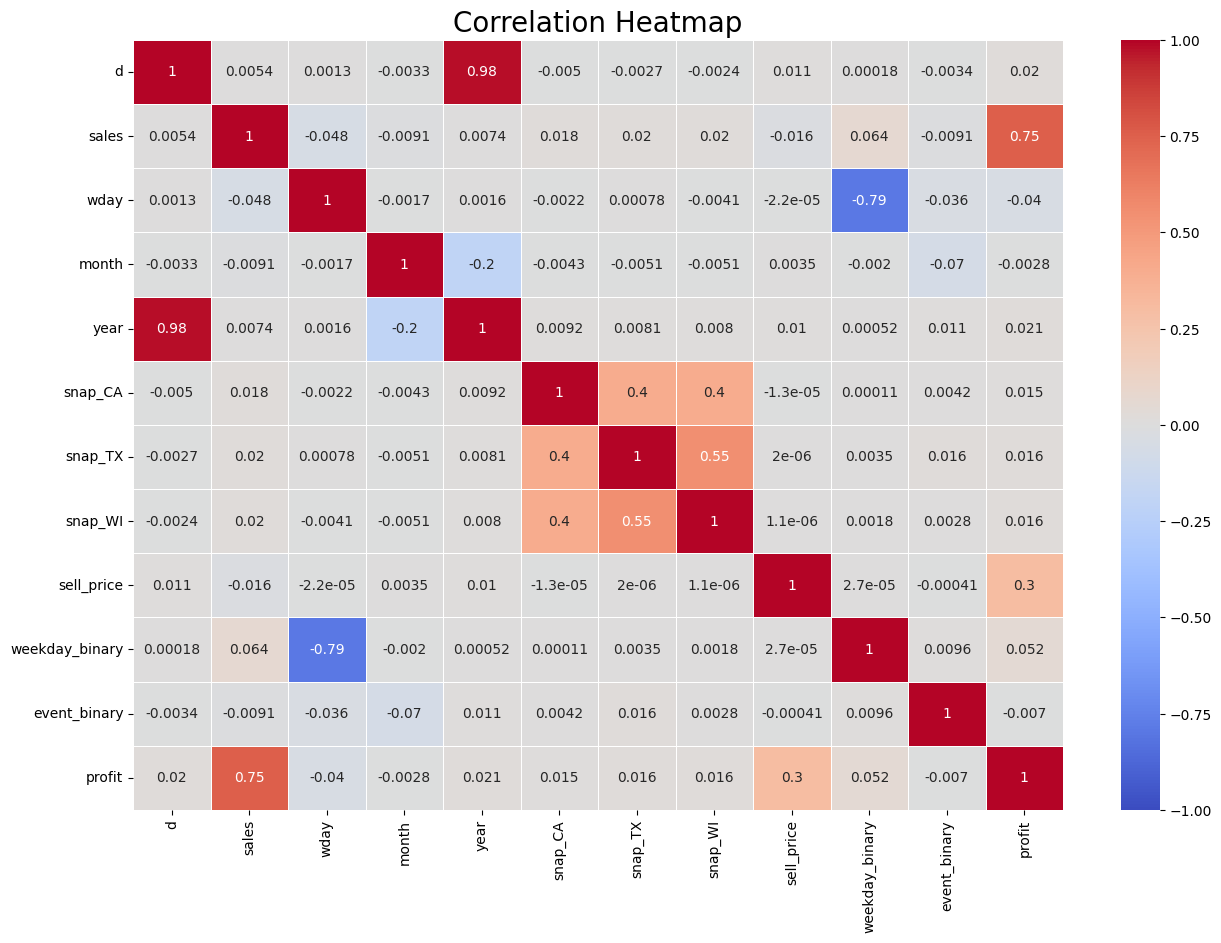

In [ ]:
corr_matrix = df.corr()

# Plotting the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Heatmap', fontsize=20)
plt.show()


In [ ]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,year,snap_CA,snap_TX,snap_WI,event_name,event_type,sell_price,weekday_binary,event_binary,profit
0,FOODS_1_011_CA_1_validation,FOODS_1_011,FOODS_1,FOODS,CA_1,CA,1,2,2011-01-29,11101,...,2011.0,0.0,0.0,0.0,NaN,NaN,2.28,1,0,4.56
1,FOODS_1_011_CA_1_validation,FOODS_1_011,FOODS_1,FOODS,CA_1,CA,10,1,2011-02-07,11102,...,2011.0,1.0,1.0,0.0,NaN,NaN,2.28,0,0,2.28
2,FOODS_1_011_CA_1_validation,FOODS_1_011,FOODS_1,FOODS,CA_1,CA,100,0,2011-05-08,11115,...,2011.0,1.0,0.0,1.0,Mother's day,Cultural,2.28,1,1,0.00
3,FOODS_1_011_CA_1_validation,FOODS_1_011,FOODS_1,FOODS,CA_1,CA,1000,0,2013-10-24,11339,...,2013.0,0.0,0.0,0.0,NaN,NaN,2.48,0,0,0.00
4,FOODS_1_011_CA_1_validation,FOODS_1_011,FOODS_1,FOODS,CA_1,CA,1001,0,2013-10-25,11339,...,2013.0,0.0,0.0,0.0,NaN,NaN,2.48,0,0,0.00


In [ ]:
df.dtypes

id                 object
item_id            object
dept_id            object
cat_id             object
store_id           object
state_id           object
d                   int64
sales               int64
date               object
wm_yr_wk           object
weekday            object
wday              float64
month             float64
year              float64
snap_CA           float64
snap_TX           float64
snap_WI           float64
event_name         object
event_type         object
sell_price        float64
weekday_binary      int64
event_binary        int64
profit            float64
dtype: object

In [ ]:
path = '../data/interim/dataxx.csv'
df.to_csv(path, index=False)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Drop rows where date is higher than 1.2.2016
df = df[df.date <= "2016-02-01"]

In [ ]:
# na zaklade parsimonie vybereme cat_id, store_id, state_id, event_binary, weekday_binary
data = df.copy()

# One-hot encode the categorical columns
encoder = OneHotEncoder(drop='first', sparse=False)
encoded_features = encoder.fit_transform(data[['store_id', 'cat_id', 'dept_id', 'item_id', 'month']])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['store_id', 'cat_id', 'dept_id', 'item_id', 'month']))

# Concatenate the original data with the encoded features
data.reset_index(drop=True, inplace=True)
encoded_df.reset_index(drop=True, inplace=True)

# Concatenate the original data with the encoded features
data = pd.concat([data, encoded_df], axis=1)

# Drop original categorical columns & any other column not used
data = data.drop(columns=['store_id', 'state_id', 'cat_id', 'month', 'item_id', 'dept_id', 'event_name', 'event_type', 'id', 'wday', 'snap_CA', 'snap_TX', 'snap_WI', 'weekday'])
print(data)
print(data.isna().sum())


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


            d  sales        date wm_yr_wk    year  sell_price  weekday_binary  \
0           1      2  2011-01-29    11101  2011.0        2.28               1   
1          10      1  2011-02-07    11102  2011.0        2.28               0   
2         100      0  2011-05-08    11115  2011.0        2.28               1   
3        1000      0  2013-10-24    11339  2013.0        2.48               0   
4        1001      0  2013-10-25    11339  2013.0        2.48               0   
...       ...    ...         ...      ...     ...         ...             ...   
1078807   995      1  2013-10-19    11339  2013.0        3.97               1   
1078808   996      0  2013-10-20    11339  2013.0        3.97               1   
1078809   997      0  2013-10-21    11339  2013.0        3.97               0   
1078810   998      0  2013-10-22    11339  2013.0        3.97               0   
1078811   999      0  2013-10-23    11339  2013.0        3.97               0   

         event_binary  prof

In [ ]:
# # Extract columns starting with 'store_id_'
# store_id_cols = [col for col in data.columns if col.startswith('store_id_')]

# for col in store_id_cols:
#     new_col_name = f"{col}_event"
#     data[new_col_name] = data[col] * data['event_binary']
# # Extract columns related to months and categories
# month_cols = [col for col in data.columns if 'month_' in col]
# cat_id_cols = [col for col in data.columns if 'cat_id_' in col]

# for month_col in month_cols:
#     for cat_col in cat_id_cols:
#         new_col_name = f"{month_col}_{cat_col}"
#         data[new_col_name] = data[month_col] * data[cat_col]
# print(data)



In [ ]:
data['wm_yr_wk'] = data['wm_yr_wk'].astype(int)
print(data['wm_yr_wk'].dtype)

int64


In [ ]:
data.dtypes

d               int64
sales           int64
date           object
wm_yr_wk        int64
year          float64
               ...   
month_8.0     float64
month_9.0     float64
month_10.0    float64
month_11.0    float64
month_12.0    float64
Length: 106, dtype: object

In [ ]:
data.head()

,d,sales,date,wm_yr_wk,year,sell_price,weekday_binary,event_binary,profit,store_id_CA_2,...,month_3.0,month_4.0,month_5.0,month_6.0,month_7.0,month_8.0,month_9.0,month_10.0,month_11.0,month_12.0
0,1,2,2011-01-29,11101,2011.0,2.28,1,0,4.56,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10,1,2011-02-07,11102,2011.0,2.28,0,0,2.28,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100,0,2011-05-08,11115,2011.0,2.28,1,1,0.00,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1000,0,2013-10-24,11339,2013.0,2.48,0,0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1001,0,2013-10-25,11339,2013.0,2.48,0,0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
